# Topic modelling for InnerSpeech dataset (Japanese)


Author : Romy Beauté\
Date created : 02/12/2024\
Last modified : 02/12/2024\
Corresp : r.beaut@sussex.ac.uk

Selection of sentence transformer embedding models :
https://www.sbert.net/docs/pretrained_models.html

The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality



In [11]:
%%capture
!pip install bertopic accelerate bitsandbytes xformers adjustText
!pip install llama-cpp-python
!{sys.executable} -m pip install "scipy==1.9.0" "scikit-image==0.23.2"

import os
import nltk
import sys
import pandas as pd

current_dir = os.getcwd()  # should be in NOTEBOOKS
lyra_dir = os.path.abspath(os.path.join(current_dir, '..'))  # go up one level
print("Lyra directory:", lyra_dir)


# Change directory and update path
os.chdir(lyra_dir)
sys.path.insert(0, lyra_dir)
print("Current working directory:", os.getcwd())
print("Python path first entry:", sys.path[0])


from grid_search_colyra import *
from META_helpers_colyra import split_sentences,reduced_custom_stopwords


os.environ["TOKENIZERS_PARALLELISM"] = "True"
nltk.download('stopwords')


condition = "innerspeech_japanese" 
sentences = True
reduced_GS = False
random_seed = 42
nr_topics = "auto" 
reports_path = os.path.join("DATA",f"{condition}.xlxs")


# # results_GS = pd.read_csv(f'/home/romy/lyra/RESULTS/grid_search_results_{condition}_seed42{"_reduced" if reduced_GS else ""}{"_sentences" if sentences else ""}.csv')


# df_reports = pd.read_csv(reports_path,sep="\t")['reflection_answer']


# if sentences:
#     df_reports = split_sentences(df_reports)

# results_GS.head(5)

In [12]:
reports_path = os.path.join("DATA", f"{condition}.xlsx")  # Fixed extension

# Verify file existence
print("Looking for file at:", os.path.abspath(reports_path))
print("Files in DATA directory:", os.listdir("DATA"))

df = pd.read_excel(reports_path).head(5)

Looking for file at: /home/romy/lyra/DATA/innerspeech_japanese.xlsx
Files in DATA directory: ['reflections_preprocessing.ipynb', 'HW_reflections_cleaned.csv', 'text_preprocessing.ipynb', 'HS_reflections_cleaned.csv', 'words_visualisation.ipynb', 'HW_reflections.csv', 'SensoryTool_CombinedData_v24_20230912_2.xlsx', 'innerspeech_japanese.xlsx', 'DL_reflections_cleaned.csv']


In [13]:
df

タイムスタンプ 性別（自認）を教えて下さい 年齢を教えて下さい  上の動画がどれだけ自分の内言として当てはまりますか？  \
0 2022-05-11 17:46:55.621            男性        35                           2   
1 2022-05-11 17:48:16.588            男性        26                           3   
2 2022-05-11 17:49:03.556            女性        21                           1   
3 2022-05-11 17:49:33.625            男性        34                           1   
4 2022-05-11 17:49:48.730            女性        53                           6   

   上の動画がどれだけ自分の内言として当てはまりますか？.1  上の動画がどれだけ自分の内言として当てはまりますか？.2  \
0                             1                             1   
1                             1                             7   
2                             1                             3   
3                             1                             1   
4                             2                             5   

   上の動画がどれだけ自分の内言として当てはまりますか？.3  上の動画がどれだけ自分の内言として当てはまりますか？.4  \
0                             1                             6   
1                             1                             3   
2                             1                             7   
3                             1                             7   
4                             1                             7   

   上の動画がどれだけ自分の内言として当てはまりますか？.5  上の動画がどれだけ自分の内言として当てはまりますか？.6  ... 内言の中に「聴覚」は  \
0                             2                             1  ...          3   
1                             1                             1  ...          6   
2                             1                             1  ...          1   
3                             1                             1  ...          1   
4                             1                             1  ...          7   

   内言の中に「嗅覚」は  内言の中に「味覚」は  内言の中に「触覚」は  あなたの内言は，  \
0           5           5           3         2   
1           2           7           3         7   
2           4           4           1         2   
3           7           7           7         1   
4           6           5           4         7   

   メールを書くときに，頭の中だけで（メモなどを取らずに）事前に文面を組み立てることは可能ですか？  \
0                                                5   
1                                                5   
2                                                1   
3                                                1   
4                                                2   

   粘土細工をつくるときに，頭の中だけで（スケッチなどをせずに）事前に完成イメージを思い浮かべることは可能ですか？  \
0                                                  2         
1                                                  3         
2                                                  4         
3                                                  1         
4                                                  5         

   どれだけあなたの内言は自らの意思決定に影響を与えますか？ どれだけ自分自身の内言を鮮明に自覚できますか？  \
0                             6                       5   
1                             5                       6   
2                             3                       5   
3                             7                       5   
4                             7                       5   

   内言について他に述べたいことがあれば自由に記述してください（任意）  
0                                NaN  
1                                NaN  
2                                NaN  
3                                NaN  
4                                NaN  

[5 rows x 38 columns]

In [14]:
colnames = pd.read_excel(reports_path).columns.tolist()
print(len(colnames), "columns:", colnames)

df = pd.read_excel(reports_path)
non_numeric_cols = df.select_dtypes(exclude=['int64', 'float64']).columns
print("Columns with non-numeric values:", non_numeric_cols.tolist())

38 columns: ['タイムスタンプ', '性別（自認）を教えて下さい', '年齢を教えて下さい', '上の動画がどれだけ自分の内言として当てはまりますか？', '上の動画がどれだけ自分の内言として当てはまりますか？.1', '上の動画がどれだけ自分の内言として当てはまりますか？.2', '上の動画がどれだけ自分の内言として当てはまりますか？.3', '上の動画がどれだけ自分の内言として当てはまりますか？.4', '上の動画がどれだけ自分の内言として当てはまりますか？.5', '上の動画がどれだけ自分の内言として当てはまりますか？.6', '上記とは異なる内言で思考している場合は教えて下さい（任意）', '上の動画がどれだけ自分の内言として当てはまりますか？.7', '上の動画がどれだけ自分の内言として当てはまりますか？.8', '上の動画がどれだけ自分の内言として当てはまりますか？.9', '上の動画がどれだけ自分の内言として当てはまりますか？.10', '上の動画がどれだけ自分の内言として当てはまりますか？.11', '上の動画がどれだけ自分の内言として当てはまりますか？.12', '上の動画がどれだけ自分の内言として当てはまりますか？.13', '上記とは異なる内言で思考している場合は教えて下さい（任意）.1', '上の動画がどれだけ自分の内言として当てはまりますか？.14', '上の動画がどれだけ自分の内言として当てはまりますか？.15', '上の動画がどれだけ自分の内言として当てはまりますか？.16', '上の動画がどれだけ自分の内言として当てはまりますか？.17', '上の動画がどれだけ自分の内言として当てはまりますか？.18', '上の動画がどれだけ自分の内言として当てはまりますか？.19', '上の動画がどれだけ自分の内言として当てはまりますか？.20', '上記とは異なる内言で思考している場合は教えて下さい（任意）.2', '内言の中に「視覚」は', '内言の中に「聴覚」は', '内言の中に「嗅覚」は', '内言の中に「味覚」は', '内言の中に「触覚」は', 'あなたの内言は，', 'メールを書くときに，頭の中だけで（メモなどを取らずに）事前に文面を組み立てることは可能ですか？', '粘土細工をつくるときに，頭の中だけで（スケッチなどをせず

In [ ]:
# dataframe of non-numeric columns
df_non_numeric = df[non_numeric_cols]
df_non_numeric.head(5)

タイムスタンプ 性別（自認）を教えて下さい 年齢を教えて下さい  \
0 2022-05-11 17:46:55.621            男性        35   
1 2022-05-11 17:48:16.588            男性        26   
2 2022-05-11 17:49:03.556            女性        21   
3 2022-05-11 17:49:33.625            男性        34   
4 2022-05-11 17:49:48.730            女性        53   

  上記とは異なる内言で思考している場合は教えて下さい（任意） 上記とは異なる内言で思考している場合は教えて下さい（任意）.1  \
0                           NaN                             NaN   
1                           NaN                             NaN   
2                           NaN                             NaN   
3                           NaN                             NaN   
4                           NaN                             NaN   

  上記とは異なる内言で思考している場合は教えて下さい（任意）.2 内言について他に述べたいことがあれば自由に記述してください（任意）  
0                             NaN                               NaN  
1                             NaN                               NaN  
2                             NaN                               NaN  
3                             NaN                               NaN  
4                             NaN                               NaN

In [16]:
non_numeric_cols[2]
# content of non_numeric_cols[2]
df_non_numeric[non_numeric_cols[2]]

#check if non numeric values in this column
df_non_numeric[non_numeric_cols[2]].unique()

array([35, 26, 21, 34, 53, 41, 22, 23, 19, 25, 38, 28, 39, 42, 24, 33, 27,
       49, 16, '26歳', 44, 47, 74, 18, 29, 40, 31, 20, 48, 37, 45, 50, 30,
       67, 32, 17, 56, '43歳', 46, '４０', 15, '42歳', 58, 36, 63, '40歳', 57,
       43, 51, 52, 54, '24歳', '４２', '２７', '２５', '23歳', 55, 14, 64, 61,
       '３４', 60, 99999999999999991433150857216, '４０歳', '30代後半', '２６',
       '31歳', '２１', '応えたくない', '３８', 62, 59, '３１', 65, '３７', '３６', 0,
       '🚩53', '４６', '10万28歳', '秘密', '40-45', 78, '３３', 72, '22歳', '４１',
       '２０', '21歳', '32歳', '39歳', 12, '68歳', 70, '20歳', 13, '56歳', '58才',
       '33歳', '２２', '３０', '38歳', '55歳', 1, 68, '25歳', 'aw', '50歳', '４３',
       11, '５６', 10, '40代', 'あ', '27歳5ヶ月', '62950262849173941871003',
       '20代', '20代後半', '３９', '１５', 69], dtype=object)

non-numeric columns translated:

- Timestamp
- Gender (self-identified)
- Age
- If you think in different inner speech than above, please tell us (optional)
- If you think in different inner speech than above, please tell us (optional).1
- If you think in different inner speech than above, please tell us (optional).2
- Please freely describe anything else about inner speech (optional)

In [17]:
#remove non_numeric_cols[0], non_numeric_cols[1], non_numeric_cols[2] from df_non_numeric
df_non_numeric = df_non_numeric.drop(columns=[non_numeric_cols[0], non_numeric_cols[1], non_numeric_cols[2]])
df_non_numeric.head(5)

上記とは異なる内言で思考している場合は教えて下さい（任意） 上記とは異なる内言で思考している場合は教えて下さい（任意）.1  \
0                           NaN                             NaN   
1                           NaN                             NaN   
2                           NaN                             NaN   
3                           NaN                             NaN   
4                           NaN                             NaN   

  上記とは異なる内言で思考している場合は教えて下さい（任意）.2 内言について他に述べたいことがあれば自由に記述してください（任意）  
0                             NaN                               NaN  
1                             NaN                               NaN  
2                             NaN                               NaN  
3                             NaN                               NaN  
4                             NaN                               NaN

In [18]:
#remove all participants that have NaN in all columns from df_non_numeric
len(df_non_numeric)
df_non_numeric = df_non_numeric.dropna(how='all')
len(df_non_numeric)

1313

In [19]:
#remane last col non_numeric_cols[-1] 'reflection_answer'
df_non_numeric = df_non_numeric.rename(columns={non_numeric_cols[-1]: 'reflection_answer'})
df_non_numeric.head(5)

上記とは異なる内言で思考している場合は教えて下さい（任意）  \
5                                                 NaN   
11                   自分の動きを考えるときは、漫画のネームみたいな感じで思い浮かべる   
14                                                NaN   
24  基本は回答した通り映像なんですが、そこに自分が財布を置いた時、触った時の体の感覚も入ってる感じです   
26                                                NaN   

   上記とは異なる内言で思考している場合は教えて下さい（任意）.1          上記とは異なる内言で思考している場合は教えて下さい（任意）.2  \
5                              NaN                                      NaN   
11                             NaN                                      NaN   
14                             NaN           味と匂いを想像し、それをいま自分が欲しているのかを自らに問う   
24                             NaN  イメージと自分の言葉に加えて、食べたいかどうかを味を想像して考えてる気がします   
26                             NaN           音声と文字のどちらかだけではなく、組み合わさっていると思う。   

                                    reflection_answer  
5   頭の中の独り言をこのような調査で改めて自覚することができ、また色々なパターンがあることを知り...  
11                                                NaN  
14  他人の声が脳内でしている人がいるという話にすごく興味があるのですが、心理物理実験で音声のパラ...  
24                                                NaN  
26  頭の中では日本語で考えているという自覚はある（英語は勉強以外にほぼ使ったことはない）が、文字...

In [20]:
#list of reflection_answer, and remove NaN values
df_reports = df_non_numeric['reflection_answer'].dropna()
df_reports.head(5)
len(df_reports)

731

In [21]:
#convert to list 
df_reports = df_reports.tolist()

In [ ]:
# import nltk
# nltk.download('stopwords')

# !pip install mecab-python3 unidic-lite
# import MeCab
# wakati = MeCab.Tagger("-Owakati")

In [22]:
sentence_transformer_model = "all-mpnet-base-v2" #"paraphrase-MiniLM-L6-v2"# #"BAAI/bge-small-en" "all-MiniLM-L6-v2'"
embedding_model = SentenceTransformer(sentence_transformer_model)
embeddings = embedding_model.encode(df_reports, show_progress_bar=True)
print(embedding_model)

# vectorizer_model = CountVectorizer(ngram_range=(1,2), stop_words=list(stopwords.words('japanese')),max_df=0.9,min_df=2)#+list(reduced_custom_stopwords)) #ngram_range=(1,2) : unigrams and bigrams
vectorizer_model = CountVectorizer(ngram_range=(1,2),max_df=0.9,min_df=2)#+list(reduced_custom_stopwords)) #ngram_range=(1,2) : unigrams and bigrams

# n_neighbors = int(chosen_params['n_neighbors'])
# n_components = int(chosen_params['n_components'])
# min_dist = float(chosen_params['min_dist'])
# min_cluster_size = int(chosen_params['min_cluster_size'])
# min_samples= int(chosen_params['min_samples']) if pd.notna(chosen_params['min_samples']) else None
# top_n_words = int(chosen_params['top_n_words'])
# nr_topics = "auto"

n_neighbors = 15# int(chosen_params['n_neighbors'])
n_components = 3 #int(chosen_params['n_components'])
min_dist = 0.01 #float(chosen_params['min_dist'])
min_cluster_size = 10# int(chosen_params['min_cluster_size'])
min_samples= None #int(chosen_params['min_samples']) if pd.notna(chosen_params['min_samples']) else None
top_n_words = 10 #int(chosen_params['top_n_words'])
nr_topics = "auto"



metric='cosine'

Batches:   0%|          | 0/23 [00:00<?, ?it/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)


In [23]:
# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=n_neighbors, n_components=2, min_dist=min_dist, metric='cosine', random_state=random_seed).fit_transform(embeddings)

umap_model = UMAP(n_neighbors=n_neighbors,
                  n_components=n_components,
                  min_dist=min_dist,
                  metric=metric,
                  random_state=random_seed) # rdm seed for reportability

hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size,
                        min_samples=min_samples,
                        # cluster_selection_epsilon=0.3,
                        gen_min_span_tree=True,
                        prediction_data=True)


In [24]:
model = BERTopic(
    umap_model=umap_model,
    low_memory=True,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words=top_n_words,
    nr_topics= nr_topics,#default to None
    language='japanese',
    calculate_probabilities=True,
    verbose=True)

topics,_ = model.fit_transform(df_reports)

coherence_score,coherence_score_umass = calculate_coherence(model, df_reports) #sanitary check for coherence, that we obtain the same score as when running GS
print("Coherence Score:", coherence_score)

print(f"n = {len(np.unique(topics))} topics extracted")


#check how many documents identified as outliers
print(len(model.hdbscan_model.labels_[model.hdbscan_model.labels_==-1]))

2024-12-02 14:52:44,285 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/23 [00:00<?, ?it/s]

2024-12-02 14:52:44,887 - BERTopic - Embedding - Completed ✓
2024-12-02 14:52:44,888 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-02 14:52:46,176 - BERTopic - Dimensionality - Completed ✓
2024-12-02 14:52:46,177 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-02 14:52:46,199 - BERTopic - Cluster - Completed ✓
2024-12-02 14:52:46,199 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-02 14:52:46,212 - BERTopic - Representation - Completed ✓
2024-12-02 14:52:46,213 - BERTopic - Topic reduction - Reducing number of topics
2024-12-02 14:52:46,226 - BERTopic - Topic reduction - Reduced number of topics from 9 to 9
2024-12-02 14:52:46,242 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/23 [00:00<?, ?it/s]

2024-12-02 14:52:46,847 - BERTopic - Embedding - Completed ✓
2024-12-02 14:52:46,847 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-02 14:52:48,135 - BERTopic - Dimensionality - Completed ✓
2024-12-02 14:52:48,135 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-02 14:52:48,156 - BERTopic - Cluster - Completed ✓
2024-12-02 14:52:48,157 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-02 14:52:48,169 - BERTopic - Representation - Completed ✓
2024-12-02 14:52:48,170 - BERTopic - Topic reduction - Reducing number of topics
2024-12-02 14:52:48,182 - BERTopic - Topic reduction - Reduced number of topics from 9 to 9


Topics: [['また', 'ただ', 'ありがとうございました', '映像', 'しかし', 'なので', 'など', '私の場合', '思い出す', 'その'], ['文章', '内言と', '全体的に', '触覚', 'どうしよう', '自分の場合', '視覚', '私の場合', 'しかし', '映像'], ['内言', 'もある', '興味深かったです', 'とても興味深いです', 'と思いました', 'また', '', '', '', ''], ['雰囲気', '他人の声で聞こえる', '', '', '', '', '', '', '', ''], ['想像', '独り言', 'それぞれ', '自分の声', '', '', '', '', '', ''], ['頑張ってください', '研究がんばってください', 'とても興味深いです', '', '', '', '', '', '', ''], ['しかし', '映像', 'ありがとうございました', '内言', '', '', '', '', '', ''], ['面白かったです', '頑張ってください', 'とても面白かったです', '', '', '', '', '', '', '']]
Coherence Score: 0.29648393884632546
n = 9 topics extracted
259


In [25]:
new_topics = model.reduce_outliers(df_reports, topics,strategy='probabilities',probabilities=_,threshold=0.2)

# Check the impact
print(f"Original outliers: {len(model.hdbscan_model.labels_[model.hdbscan_model.labels_==-1])}")
print(f"Remaining outliers after reduction: {len([t for t in topics if t == -1])}")

# #print the sentences that are identified as outliers after reduction
# outliers = np.where(np.array(topics)==-1)[0]
# for i in outliers:
#     print(df_reports[i])

# Verify coherence is maintained
model.topics_ = new_topics
coherence_score, coherence_score_umass = calculate_coherence(model, df_reports)
print(f"New coherence score: {coherence_score:.4f}")

2024-12-02 14:52:57,638 - BERTopic - Embedding - Transforming documents to embeddings.


Original outliers: 259
Remaining outliers after reduction: 259


Batches:   0%|          | 0/23 [00:00<?, ?it/s]

2024-12-02 14:52:58,235 - BERTopic - Embedding - Completed ✓
2024-12-02 14:52:58,236 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-02 14:52:59,820 - BERTopic - Dimensionality - Completed ✓
2024-12-02 14:52:59,821 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-02 14:52:59,842 - BERTopic - Cluster - Completed ✓
2024-12-02 14:52:59,843 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-02 14:52:59,856 - BERTopic - Representation - Completed ✓
2024-12-02 14:52:59,856 - BERTopic - Topic reduction - Reducing number of topics
2024-12-02 14:52:59,868 - BERTopic - Topic reduction - Reduced number of topics from 9 to 9


Topics: [['また', 'ただ', 'ありがとうございました', '映像', 'しかし', 'なので', 'など', '私の場合', '思い出す', 'その'], ['文章', '内言と', '全体的に', '触覚', 'どうしよう', '自分の場合', '視覚', '私の場合', 'しかし', '映像'], ['内言', 'もある', '興味深かったです', 'とても興味深いです', 'と思いました', 'また', '', '', '', ''], ['雰囲気', '他人の声で聞こえる', '', '', '', '', '', '', '', ''], ['想像', '独り言', 'それぞれ', '自分の声', '', '', '', '', '', ''], ['頑張ってください', '研究がんばってください', 'とても興味深いです', '', '', '', '', '', '', ''], ['しかし', '映像', 'ありがとうございました', '内言', '', '', '', '', '', ''], ['面白かったです', '頑張ってください', 'とても面白かったです', '', '', '', '', '', '', '']]
New coherence score: 0.2965


In [26]:
# topics = new_topics
_, probabilities = model.transform(df_reports)

print(f"Number of unique topics after update: {len(np.unique([t for t in topics if t != -1]))}")
print(f"Number of remaining outliers: {len([t for t in topics if t == -1])}")


Batches:   0%|          | 0/23 [00:00<?, ?it/s]

2024-12-02 14:53:04,574 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-12-02 14:53:04,577 - BERTopic - Dimensionality - Completed ✓
2024-12-02 14:53:04,577 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-12-02 14:53:04,589 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2024-12-02 14:53:04,628 - BERTopic - Probabilities - Completed ✓
2024-12-02 14:53:04,628 - BERTopic - Cluster - Completed ✓


Number of unique topics after update: 8
Number of remaining outliers: 259


In [27]:
model.visualize_barchart(title=f'Topic Word Scores for {condition}',autoscale=True)

In [28]:
model.visualize_documents(df_reports,title=f'Documents and Topics for {condition}')

# LLAMA 3

In [29]:
# !CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python
# # !wget https://huggingface.co/TheBloke/zephyr-7B-alpha-GGUF/resolve/main/zephyr-7b-alpha.Q4_K_M.gguf

# # DataMapPlot
# !git clone https://github.com/TutteInstitute/datamapplot.git
# !pip install datamapplot/.

import datamapplot
import torch
torch.cuda.empty_cache()

# # Remove existing installations
# !pip uninstall -y cudf cuml cugraph cupy rmm

# Install RAPIDS packages in correct order
!pip install --upgrade rmm-cu12 --extra-index-url=https://pypi.nvidia.com/simple
!pip install --upgrade cudf-cu12 --extra-index-url=https://pypi.nvidia.com/simple
!pip install --upgrade cuml-cu12 --extra-index-url=https://pypi.nvidia.com/simple

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com/simple
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com/simple
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com/simple


In [30]:
from huggingface_hub import hf_hub_download  # For loading the model instance from Hugging Face
import os  # For creating system directories
from llama_cpp import Llama  # LLM Wrapper
from bertopic.representation import KeyBERTInspired, LlamaCPP  # Representation Comparison
from sentence_transformers import SentenceTransformer  # Embedding Model Wrapper

from bertopic import BERTopic  # For topic modeling with BERTopic
import PIL  # For image processing
import numpy as np  # For numerical computations
import requests  # For making HTTP requests
import re  # For regular expressions


#to speed up computation
import torch
torch.cuda.empty_cache()
from cuml.manifold import UMAP  # For UMAP dimensionality reduction
from cuml.cluster import HDBSCAN  # For clustering with HDBSCAN

#add periodic memory clearing (use if too slow to run)
def process_batch(batch):
    results = []
    for item in batch:
        results.append(process_item(item))
        if len(results) % 100 == 0:  # Clear memory every 100 items
            torch.cuda.empty_cache()
    return results


In [31]:
model_name_or_path = "NousResearch/Meta-Llama-3-8B-Instruct-GGUF"
model_basename = "Meta-Llama-3-8B-Instruct-Q4_K_M.gguf"
os.makedirs('model', exist_ok=True)
path = "model"


# Downloading the model from repo
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename, cache_dir=path)

# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path=model_path, n_gpu_layers=-1, n_ctx=4096, stop=["Q:", "\n"],verbose=False)

In [32]:



prompt = """Q:
Topic documents:
[DOCUMENTS]

Topic keywords: '[KEYWORDS]'

Find the most appropriate scientific label for this topic based on the above information. The label should:

1. Uses Title Case with proper spacing
2. Avoids abstract interpretations
4. Be concise yet comprehensive (2-5 words max)

Only return the label itself, without any additional text or punctuation.
A:
"""

pipeline_kwargs = {
    "max_tokens": 10,      # Default varies
    # Controls maximum length of response
    # 10 is good for 2-3 word labels
    
    "temperature": 0.3,    # conservative to minimise randomness and hallucinations
    
    "top_p": 0.5,         # Default is usually 1.0
    # Range: 0 to 1
    # 0.9: Consider 90% most likely tokens
    # Focus on most probable tokens from the input
    
    "repeat_penalty": 2  # Default is usually 1.0
    # >1.0: Penalize repeated words
    # Useful for avoiding redundant terms in labels
}

representation_model = {
   "KeyBERT": KeyBERTInspired(),
   "LLM": LlamaCPP(llm, prompt=prompt,nr_docs=6,pipeline_kwargs=pipeline_kwargs)
}





In [33]:
torch.cuda.empty_cache()

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,
  nr_topics = nr_topics,
  calculate_probabilities=True,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(df_reports,embeddings)

# Show topics
topic_model.get_topic_info()



2024-12-02 14:53:28,548 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-02 14:53:29,847 - BERTopic - Dimensionality - Completed ✓
2024-12-02 14:53:29,848 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-02 14:53:29,870 - BERTopic - Cluster - Completed ✓
2024-12-02 14:53:29,871 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 9/9 [01:28<00:00,  9.80s/it]
2024-12-02 14:54:58,395 - BERTopic - Representation - Completed ✓
2024-12-02 14:54:58,395 - BERTopic - Topic reduction - Reducing number of topics
100%|██████████| 9/9 [01:24<00:00,  9.43s/it]
2024-12-02 14:56:23,632 - BERTopic - Topic reduction - Reduced number of topics from 9 to 9


Topic  Count                                               Name  \
0     -1    259                               -1_内言_自分の声_映像_と思いました   
1      0    204                            0_また_ただ_例えば_ありがとうございました   
2      1     70  1_文章_webデザイン職ですが_映像付きの音声言語的な情報として思い浮かべるが_普段何もし...   
3      2     69  2_内言_1つ目の設問の通りです_思考というものを完全に内言という物に頼っていたことに気が付...   
4      3     52  3_考えるとき_4次元程度の空間で思考を行っていた_思春期時代_幼少期の頃から未だにイマジナ...   
5      4     33  4_自分の声_1人でいるときに考える場合と_大学生くらいの頃まで頭の中に他人がいて_自分の声...   
6      5     20                     5_cqcq_音ではないが情報量の多いかんじ_なし_fb21   
7      6     13  6_bgmだけ流れていることも多い_少なくとも起きている間_自分の声で思考する_脳内の言語化...   
8      7     11     7_面白かったです_twitterでみて来ました_を考えて言葉にする_に話をして楽しい話題か   

                                      Representation  \
0  [内言, 自分の声, 映像, と思いました, また, なので, しかし, について, 状況,...   
1  [また, ただ, 例えば, ありがとうございました, 映像, しかし, 内言, なので, な...   
2  [文章, webデザイン職ですが, 映像付きの音声言語的な情報として思い浮かべるが, 普段何...   
3  [内言, 1つ目の設問の通りです, 思考というものを完全に内言という物に頼っていたことに気が...   
4  [考えるとき, 4次元程度の空間で思考を行っていた, 思春期時代, 幼少期の頃から未だにイマ...   
5  [自分の声, 1人でいるときに考える場合と, 大学生くらいの頃まで頭の中に他人がいて, 自分...   
6  [cqcq, 音ではないが情報量の多いかんじ, なし, fb21, おもしろい研究だと思いま...   
7  [bgmだけ流れていることも多い, 少なくとも起きている間, 自分の声で思考する, 脳内の言...   
8  [面白かったです, twitterでみて来ました, を考えて言葉にする, に話をして楽しい話...   

                                             KeyBERT  \
0  [日本語の内言は自分が作っている感覚があるが, 現実での他者の会話も含めて全て音声言語は文字...   
1  [自分の場合, 自分の場合は, 私の場合は, 私の場合, 内言の声は, 映像の内言の代わりに...   
2  [文章を書く場合などは頭の中でも文章を書きながら脳内で音読しつつ, 文章を考えながら映像つけ...   
3  [祈ると内言の方向性や内容が変化するという体験がある, 自分の声による内言は独り言を出す場合...   
4  [それをパラパラとページをめくっているようなイメージです, 自分と他の誰かがインタビューにそ...   
5  [人と会話しているときは自分の声で思考していますが, もう一人の自分と会話してる感覚です, ...   
6  [また幸福度にも関わります, 研究応援しています, これが大切なのです, 自分のｑｏｌに大き...   
7  [と映像で自分の考えていることが頭の中で再生されているような感じがしています, 自分がどのよ...   
8  [面白い研究だなと思いました, とても面白かったです, その上ぼうっとしてるといつのまにかド...   

                                                 LLM  \
0  [Cognitive Phenomena\n\nNote:\nThe topic, , , ...   
1  [Cognitive Processes\n\nNote that this topic i...   
2  [Cognitive Processing\n\nNote:\nThe topic keyw...   
3  [Cognitive Processes\n\nNote that this topic i...   
4  [Cognitive Processes\n\nNote:\nThe topic keywo...   
5  [Internal Dialogue\n\nNote:\nThe provided topi...   
6  [Cognitive Decision Making\n\nNote:\nThe topic...   
7  [Cognitive Processes\n\nNote:\nThe topic keywo...   
8  [Cognitive Processes\n\nNote:\nThe topic keywo...   

                                 Representative_Docs  
0  [　映像（短い動画・静止映像）もぼんやり映りますが、主に言語（自分の声）で考えます。延々と頭...  
1  [どこかでも書きましたが、「頭の中の水面に波紋を浮かべて、波紋の強いところから連想して思考を...  
2  [子供のころ内言が映像から言語ベースに移り替わっていった過渡期の記憶がある。小学生低学年まで...  
3  [内言が出来ると気づいた時の事を鮮明に覚えている。声を出さずに喋れる、と気づいた。おそらく3...  
4  [考えるとき、関連する映像や場面がファイリングされていて、それをパラパラとページをめくってい...  
5  [「自分と他人の対話」と「自分の声」の派生(?)として「自分①と自分②の対話」がよく発生しま...  
6  [CQCQ これが大切なのです  Fb21, 補足になりますが、フローチャートも映像(または...  
7  [常にどれか一つの内言のみではなく、状況によっては、映像優位になったり自問自答音声が優先され...  
8  [全くなにもないところからの空想も私は映像で思い浮かべるので、完璧に視覚優位なのだなと自覚し...

In [34]:
# outlier reduction using embeddingd
new_topics = topic_model.reduce_outliers(df_reports, topics,strategy='probabilities',probabilities=probs,threshold=0.2)

# Check the impact
print(f"Original outliers: {len(topic_model.hdbscan_model.labels_[topic_model.hdbscan_model.labels_==-1])}")
print(f"Remaining outliers after reduction: {len([t for t in new_topics if t == -1])}")

topic_model.topics_ = new_topics
topics = new_topics

# #print the sentences that are identified as outliers after reduction
# outliers = np.where(np.array(new_topics)==-1)[0]
# for i in outliers:
#     print(df_reports[i])



Original outliers: 259
Remaining outliers after reduction: 167


In [35]:



llm_labels = [label[0][0].replace('\nThe topic is labeled as:','').replace('\n', '').replace('Label:', '').replace('"', '') for label in topic_model.get_topics(full=True)["LLM"].values()]

llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]

all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in new_topics] 

filtered_labels = [label for label in all_labels if label != "Unlabelled"] #remove -1 topics (outliers)



#set topic labels for visu
unique_topics = sorted(set(topics))
topic_labels = {topic_id: llm_labels[i] for i, topic_id in enumerate(unique_topics) if topic_id != -1}
topic_model.set_topic_labels(topic_labels)

topic_labels

{0: 'Cognitive Processes',
 1: 'Cognitive Processing',
 2: 'Cognitive Processes',
 3: 'Cognitive Processes',
 4: 'Internal Dialogue',
 5: 'Cognitive Decision Making',
 6: 'Cognitive Processes',
 7: 'Cognitive Processes'}

In [36]:
topic_model.visualize_documents(df_reports, title=f"Documents and Topics for {condition} (Llama 3)",
hide_annotations=True, hide_document_hover=False, custom_labels=True)

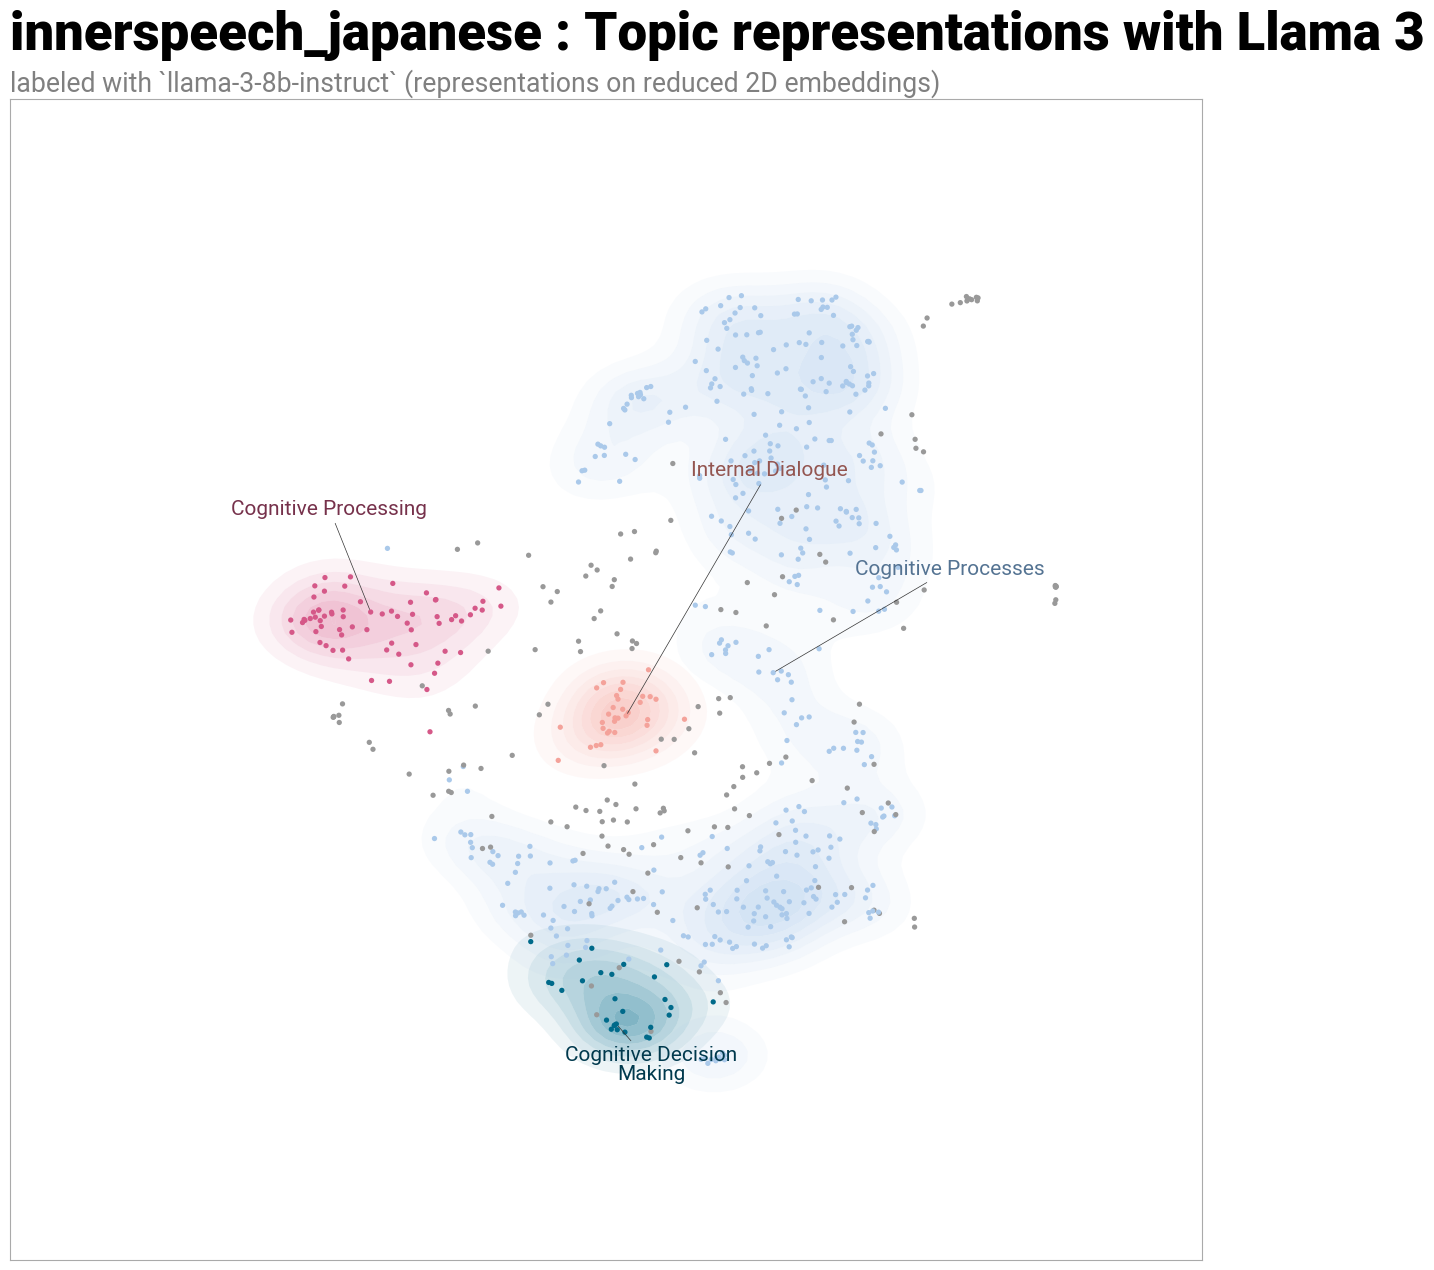

In [37]:
# Run the visualization
datamapplot.create_plot(
   reduced_embeddings,
   all_labels,
   label_font_size=15,
   title=f"{condition} : Topic representations with Llama 3",
   sub_title="labeled with `llama-3-8b-instruct` (representations on reduced 2D embeddings)",
   label_wrap_width=20,
   use_medoids=True
);

In [ ]:
help(topic_model.visualize_hierarchy)

In [ ]:
topic_model.hierarchical_topics

In [ ]:

hierarchy_vis = topic_model.visualize_hierarchy(custom_labels=True, color_threshold=.8)
hierarchy_vis

In [ ]:
help(topic_model.visualize_hierarchy())

In [ ]:
# Create a DataFrame with topic statistics and content
topic_analysis = pd.DataFrame({
    'Topic_Label': all_labels,
    'Topic_Content': df_reports,
    'Topic_Number': topics
}).reset_index()

# Get topic counts and contents
topic_summary = (
    topic_analysis
    .groupby(['Topic_Label', 'Topic_Number'])
    .agg({
        'index': 'count',  # Count of sentences
        'Topic_Content': lambda x: list(x)  # List of all sentences
    })
    .rename(columns={'index': 'Sentence_Count'})
    .sort_values('Sentence_Count', ascending=False)
    .reset_index()
)

# # Print summary for each topic
# for _, row in topic_summary.iterrows():
#     print(f"\n{'='*80}")
#     print(f"Topic Label: {row['Topic_Label']}")
#     print(f"Number of sentences: {row['Sentence_Count']}")
#     print("\nSentences in this topic:")
#     for i, sentence in enumerate(row['Topic_Content'], 1):
#         print(f"{i}. {sentence}")

# Save to CSV if needed
# topic_summary.to_csv(f'topic_analysis_{condition}.csv', index=False)

# Display DataFrame
print("\nSummary DataFrame:")
print(topic_summary[['Topic_Label', 'Topic_Number', 'Sentence_Count']])

In [ ]:
# Create basic hierarchical visualization
hierarchy_vis = topic_model.visualize_hierarchy(
    custom_labels=True,           
    orientation='left',           
    width=1200,                  
    height=800,                  
    color_threshold=0.6,         # Increased to show more color variation
    title='<b>Hierarchical Clustering</b>'
)

# Update the dendrogram colors and layout
hierarchy_vis.update_layout(
    margin=dict(l=300, r=50, t=100, b=50),
    plot_bgcolor='white',
    paper_bgcolor='white',
    showlegend=False,
    template='plotly_white'  # Moved template here
)

# Update the trace colors
hierarchy_vis.update_traces(
    marker_color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
)

hierarchy_vis.show()

In [ ]:
# Create your own palette by replacing these hex codes
custom_colors = [
    '#264653',  # Dark blue
    '#2a9d8f',  # Teal
    '#e9c46a',  # Gold
    '#f4a261',  # Peach
    '#457b9d',  # Light blue
    '#a8dadc',  # Pale blue
    '#e76f51'   # Coral
]

hierarchy_vis.update_traces(marker_color=custom_colors)

In [ ]:
hierarchy_vis = topic_model.visualize_hierarchy(
    custom_labels=True,           
    orientation='left',           
    width=1200,                  
    height=800,                  
    color_threshold=0.8,         # Controls the main category groupings
    title='<b>Hierarchical Clustering</b>'
)

# Simple professional color scheme
colors = [
    '#457b9d',  # Blue
    '#457b9d',  # Same blue to group related topics
    '#1d3557',  # Dark blue
    '#1d3557'   # Same dark blue to group related topics
]

# Update only marker color
hierarchy_vis.update_traces(
    marker_color=colors
)

hierarchy_vis.update_layout(
    margin=dict(l=300, r=50, t=100, b=50),
    plot_bgcolor='white',
    paper_bgcolor='white',
    showlegend=False,
    template='plotly_white'
)

hierarchy_vis.show()